In [ ]:
%load_ext autoreload
%autoreload 2

# Intro

In this tutorial we will demonstrate how to apply the Scarlet deblender to blends created from BTK. It assumes you are familiar with the quickstart tutorial: ``00-quickstart.ipynb``.

You also need to ensure that you have scarlet installed following the instructions here: **XYZ**

# Setup

First, we will need to import the relevant python packages and modules:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import btk

In [ ]:
import scarlet # should run without error

Now we will setup the draw blend generator for creating BTK blends. We copy the same one from the quickstart tutorial.

In [ ]:
max_n_sources = 3
stamp_size = 24.0
seed = 0
max_shift = 2.0

catalog = btk.catalog.CatsimCatalog.from_file('../data/input_catalog.fits')
sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources, min_number=max_n_sources, # always 3 sources in every blend.
    stamp_size=stamp_size, 
    max_shift=2.0, # shift is only 2 arcsecs = 10 pixels, which means blends are likely.
    min_mag = 24, max_mag = 25,
    seed = seed)
LSST = btk.survey.get_surveys('LSST')

batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=seed, # use same seed here
)

In [ ]:
blend_batch = next(draw_generator)
blend_batch

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [100, 6, 120, 120]
	 isolated_images: np.ndarray, shape [100, 3, 6, 120, 120]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 100
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)

# Run scarlet

We can use the `Scarlet` class from BTK to run scarlet on the blend generated. 

In [ ]:
# use default scarlet settings, but can be customized here (see API)
deblender = btk.deblend.Scarlet(max_n_sources) 

Scarlet needs detections to deblend sources. We pass in the truth catalog as the `reference_catalog` which are the detections it uses.

In [ ]:
deblend_ex = deblender.deblend(0, blend_batch, reference_catalogs=blend_batch.catalog_list)
deblend_ex

DeblendExample(max_n_sources = 3, n_bands = 6, image_size = 120), 
 containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: None
	deblended_images: <class 'numpy.ndarray'>, shape [3, 6, 120, 120]

# Evaluation

Let's compare the results of running scarlet with the true values. We will run Scarlet on entire batch and compare the ellipticities of true images with deblended images.

In [ ]:
# run on scarlet on entire batch.
# Scarlet takes a while, ~1.5 min for 100 blends. 
deblend_batch = deblender(blend_batch, njobs=1, reference_catalogs=blend_batch.catalog_list)

**Note:** Initialization can fail in Scarlet for a variety of reasons, we have catched the exception which is a `LinAlg` error. When this exception happens we return an empty catalog and zeroed out `deblend_images`. You can see how many errors occurred:

In [ ]:
n_failures = np.sum([len(cat) == 0 for cat in deblend_batch.catalog_list], axis=0)
n_failures

1

Matching to exclude failures:

In [ ]:
from btk.match import PixelHungarianMatcher

matcher = PixelHungarianMatcher(pixel_max_sep=5.0 # maximum separation to consider match, in pixels
)
true_catalog_list = blend_batch.catalog_list
pred_catalog_list = deblend_batch.catalog_list
matching = matcher(true_catalog_list, pred_catalog_list) # matching object

Now for measuring ellipticity we can follow the example in the `quickstart` tutorial: 

In [ ]:
from btk.measure import get_ksb_ellipticity

#obtaining images
iso_images1 = blend_batch.isolated_images[:, :, 2] # use r-band
iso_images2 = deblend_batch.deblended_images[:, :, 2] 
psf_r = blend_batch.psf[2] # psf in r-band

#matching
iso_images_matched1 = matching.match_true_arrays(iso_images1)
iso_images_matched2 = matching.match_pred_arrays(iso_images2)

#compute ellipticity
ellips1 = get_ksb_ellipticity(iso_images_matched1, psf_r, pixel_scale=0.2)

# NOTE: assumed deblended images are psf convolved with same psf
ellips2 = get_ksb_ellipticity(iso_images_matched2, psf_r, pixel_scale=0.2) 


# mask nan's (non-matches), look at first component only
e11 = ellips1[:, :, 0].flatten()
e12 = ellips2[:, :, 0].flatten()

mask = (~np.isnan(e12)) & (np.abs(e12) < 1) & (~np.isnan(e11))
e11 = e11[mask]
e12 = e12[mask]

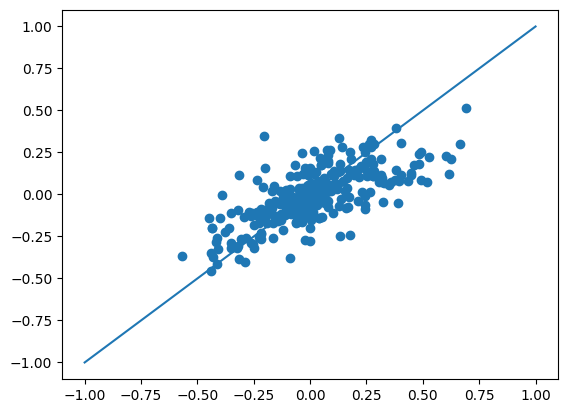

In [ ]:
# look at first component 
plt.scatter(e11, e12)
plt.plot([-1, 1], [-1, 1])